In [ ]:
import pandas as pd
import numpy as np

import scipy.io
import math
import os
import random
import statistics
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score as f1s
from sklearn.metrics import recall_score as recalls
from sklearn.metrics import precision_score as precisions
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.model_selection import LeaveOneOut
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mat = scipy.io.loadmat('subj01/sess02/cond0013/trial019.mat')

#**Visualization**

306


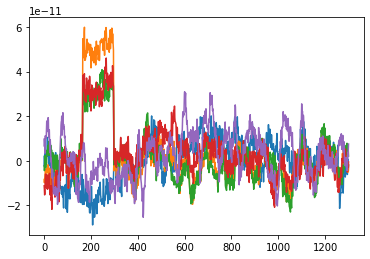

In [ ]:
mat = scipy.io.loadmat('subj01/sess02/cond0013/trial019.mat')
trial_13_19= np.array((306, 1300))
trial_13_19= mat.get('F')
print(len(trial_13_19))
preprocessing.Normalizer(trial_13_19)
y = np.var(trial_13_19, axis=1)
five_feature= np.sort(y)
idx=[]
# five feature with max var
for i in range(len(y)):
  if y[i]>= five_feature[301]:
    idx.append(i)
for i in idx:
  plt.plot(trial_13_19[i])
plt.show()

306


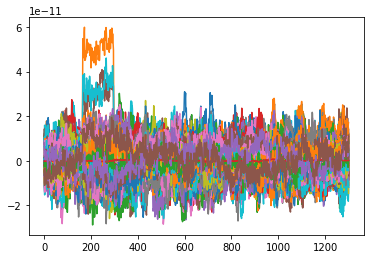

In [ ]:
# all of the features in one trial related to face.
mat = scipy.io.loadmat('subj01/sess02/cond0013/trial019.mat')
trial_13_19= np.array((306, 1300))
trial_13_19= mat.get('F')
print(len(trial_13_19))
preprocessing.Normalizer(trial_13_19)
for i in range(len(y)):
  plt.plot(trial_13_19[i])
plt.show()

#Preparing dataset

In this section, I count the number of trials that the subject have seen face and object seprately, to use this information for deciding the dimentionality of my dataset.

In [ ]:
face_number = 0
for i in range(13, 24):
    face_number += len([name for name in os.listdir("subj01/sess01/cond00%s" %i)])
print("number of faces trials: %s" %face_number)
object_number = 0
for i in range(1, 92):
  if i in range(73,76) or i in range(78,80) or i in range(83,85) or i in range(88,89):
    object_number += len([name for name in os.listdir("subj01/sess01/cond00%s" %i)])
print("number of small objects trials: %s" %object_number)

number of faces trials: 219
number of small objects trials: 160


Then, I make two different and seprate dictionary to store the datasets of objects and faces trials. The keys of this dictioneryis are the exact time points of that vectors. This help me to have access to dataset in each time of training the SVM. The values of this dictineries are 2d arrays to store the 306 features related to each triales in different time points.

In [ ]:
#face_data: a dictionary to have the vectors related to faces in each ms
face_data= {i:np.zeros(shape=(face_number,306)) for i in range(0, 1300) }
k=0
for i in range(13, 24):
  for filename in os.listdir("subj01/sess01/cond00%s" %i):
    mat = scipy.io.loadmat("subj01/sess01/cond00"+str(i)+"/"+ str(filename))
    for j in range(0, 1300):
      face_data[j][k]= mat.get('F')[:, j]
    k+=1

In [ ]:
#object_data: a dictionary to have the vectors related to objects in each ms
object_data= {i:np.zeros(shape=(object_number,306)) for i in range(0, 1300) }
k=0
for i in range(1, 92):
  if i in range(73,76) or i in range(78,80) or i in range(83,85) or i in range(88,89):
    for filename in os.listdir("subj01/sess01/cond00%s" %i):
      mat = scipy.io.loadmat("subj01/sess01/cond00"+str(i)+"/"+ str(filename))
      for j in range(0, 1300):
        object_data[j][k]= mat.get('F')[:, j]
      k+=1

In [ ]:
object_data_size=len(object_data[1])
print(object_data_size)
face_data_size=len(face_data[1][1])
print(face_data_size)

160
306


# without feature selection(with LOO)
After runing the iteration without LOO several time both with Normalizer and without it, I decided to keep it as it will iprove the accuracy.

Finally, in order to calculate accuracy, we run the SVM and LOO process on 1300 different data sets related to various time points, and measure the the accuracy in each point as a mean of LOO results.

In [ ]:
#######################since the runtime of colab interupt several time, I print the output and save it in the file in order to plot it.####################################
# from google.colab import files
# import io

# uploaded = files.upload()

Saving acc2.txt to acc2.txt


In [ ]:
accuracy=[]
for f in uploaded.keys():
    file = open(f, 'r')
    for lines in file.readlines():
      accuracy.append(float(lines.split()[3]))

In [ ]:
accuracy = []
f1_score = []
recall_score = []
precision_score = []

for i in range(0, 1300):
  
  #concat two classes to get a complete dta set of all of our samples
  data=np.concatenate((face_data[i], object_data[i]), axis=0)
  data_len=len(data)
  
  # normalize data
  data= preprocessing.normalize(data, norm="l1")
  scaler = MinMaxScaler()
  data = scaler.fit_transform(data)
  
  # len of two classes
  object_data_size=len(object_data[i])
  face_data_size=len(face_data[i])
  
  # creating lables for our final dataset
  y=np.zeros(data_len)
  for j in range(data_len):
    if j in range(0, face_data_size):
      y[j]=1
    else:
      y[j]=0
  
  # if you do not want to use LOO un comment this line to generate random index and seprate list base on that (the lines for sampling is omitted)
  # random_list=random.sample(range(0, data_len), math.floor(data_len*.1))
  
  loo = LeaveOneOut()
  
  #for using Chi2(replace data with X_chi2 if you want to use it.)
  # X_chi2 = SelectKBest(chi2, k=200).fit_transform(data, y)
  
  accuracy_loo = []
  f1_score_loo = []
  recall_score_1oo = []
  precision_score_loo = []
  
  clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

  for train_index, test_index in loo.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    y_pred=clf.predict(X_test)
    
    accuracy_loo.append(clf.score(X_test, y_test, sample_weight=None))
    # f1_score_loo.append(f1s(y_test, y_pred))
    # recall_score_1oo.append(recalls(y_test,y_pred))
    # precision_score_loo.append(precisions(y_test,y_pred))
  
  # f1_score.append(statistics.mean(f1_score_loo))
  # recall_score.append(statistics.mean(recall_score_1oo))
  # precision_score.append(statistics.mean(precision_score_loo))
  accuracy_per_iter = statistics.mean(accuracy_loo)
  
  accuracy.append(statistics.mean(accuracy_loo))
  print("iteration" +str(i)+"        accuracy = "+ str(accuracy_per_iter))

iteration0        accuracy = 0.5461741424802111
iteration1        accuracy = 0.5514511873350924
iteration2        accuracy = 0.5171503957783641
iteration3        accuracy = 0.5277044854881267
iteration4        accuracy = 0.5356200527704486
iteration5        accuracy = 0.5171503957783641
iteration6        accuracy = 0.5488126649076517
iteration7        accuracy = 0.5224274406332454
iteration8        accuracy = 0.554089709762533
iteration9        accuracy = 0.5329815303430079
iteration10        accuracy = 0.5593667546174143
iteration11        accuracy = 0.5620052770448549
iteration12        accuracy = 0.5356200527704486
iteration13        accuracy = 0.5461741424802111
iteration14        accuracy = 0.5857519788918206
iteration15        accuracy = 0.5593667546174143
iteration16        accuracy = 0.5620052770448549
iteration17        accuracy = 0.5883905013192612
iteration18        accuracy = 0.5672823218997362
iteration19        accuracy = 0.5461741424802111
iteration20        accuracy = 0

In [ ]:
print(max(accuracy))

0.8126649076517151


In [ ]:
print(accuracy)

[0.5461741424802111, 0.5514511873350924, 0.5171503957783641, 0.5277044854881267, 0.5356200527704486, 0.5171503957783641, 0.5488126649076517, 0.5224274406332454, 0.554089709762533, 0.5329815303430079, 0.5593667546174143, 0.5620052770448549, 0.5356200527704486, 0.5461741424802111, 0.5857519788918206, 0.5593667546174143, 0.5620052770448549, 0.5883905013192612, 0.5672823218997362, 0.5461741424802111, 0.5778364116094987, 0.6068601583113457, 0.5672823218997362, 0.5277044854881267, 0.554089709762533, 0.554089709762533, 0.554089709762533, 0.5514511873350924, 0.5488126649076517, 0.5514511873350924, 0.5488126649076517, 0.5488126649076517, 0.5699208443271768, 0.5514511873350924, 0.5488126649076517, 0.5356200527704486, 0.5303430079155673, 0.554089709762533, 0.5488126649076517, 0.5593667546174143, 0.5620052770448549, 0.5303430079155673, 0.5356200527704486, 0.5408970976253298, 0.5303430079155673, 0.5620052770448549, 0.5408970976253298, 0.525065963060686, 0.5725593667546174, 0.5778364116094987, 0.551

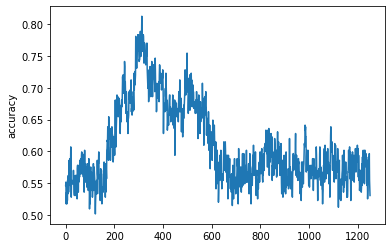

In [ ]:
x = [*range(1252)] 
plt.plot(x,accuracy)
plt.ylabel('accuracy')
plt.show()

# Results from training and measuing accuracy without LOO(using random number instead) 
test data consists of 10 percent of dataset(without noramlizing the data)

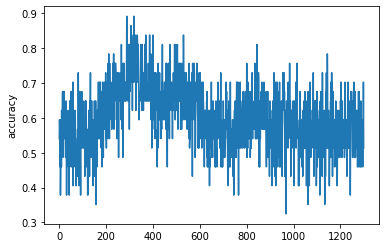

In [ ]:
x = [*range(1300)] 

plt.plot(x,accuracy)
plt.ylabel('accuracy')
plt.show()

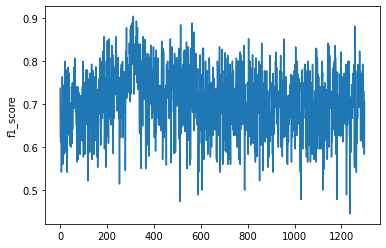

In [ ]:
plt.plot(x,f1_score)
plt.ylabel('f1_score')
plt.show()

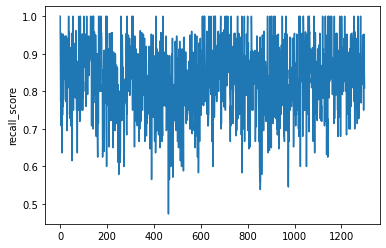

In [ ]:
plt.plot(x,recall_score)
plt.ylabel('recall_score')
plt.show()

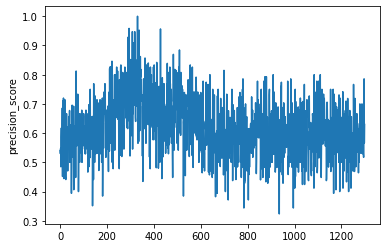

In [ ]:
plt.plot(x,precision_score)
plt.ylabel('precision_score')
plt.show()

# using Chi2 feature selection to check the results accuracy to decide on desirable K

This plot is related to deciding K = 150 feature based on Chi2
I decide this range for plotting because of difficulty of plotting the whole range(time expensive), and this range is the range of maximum accuracy due to my experience with other tries.

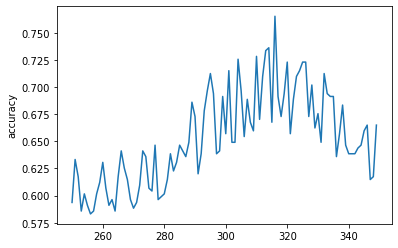

In [ ]:
x = [*range(250,350)] 

plt.plot(x,accuracy)
plt.ylabel('accuracy')
plt.show()


I also try chi2 without LOO with K=200 and the result was following

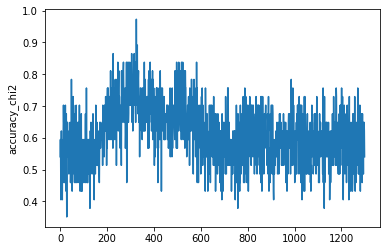

In [ ]:
plt.plot(x,accuracy_chi2)
plt.ylabel('accuracy_chi2')
plt.show()

comparing maximum accuracy of using chi2 and not using it(with out using LOO method)

In [ ]:
print(max(accuracy_chi2))
print(max(accuracy))

0.972972972972973
0.972972972972973


# Selecting 20 features that have the maximum var

306


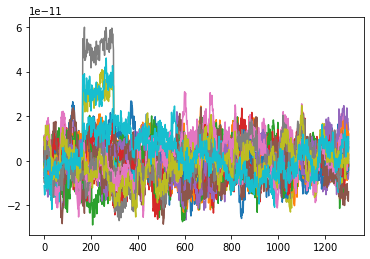

In [ ]:
mat = scipy.io.loadmat('subj01/sess02/cond0013/trial019.mat')
trial_13_19= np.array((306, 1300))
trial_13_19= mat.get('F')
print(len(trial_13_19))
preprocessing.Normalizer(trial_13_19)
y = np.var(trial_13_19, axis=1)
five_feature= np.sort(y)
# print(five_feature)
idx=[]
for i in range(len(y)):
  if y[i]>= five_feature[286]:
    idx.append(i)
for i in idx:
  plt.plot(trial_13_19[i])
plt.show()

the plot without using LOO(10 percent of data was test they were selected random based)

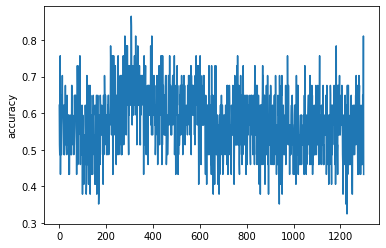

In [ ]:
x = [*range(1300)] 

plt.plot(x,accuracy)
plt.ylabel('accuracy')
plt.show()

Using LOO with 20 feature which had max var

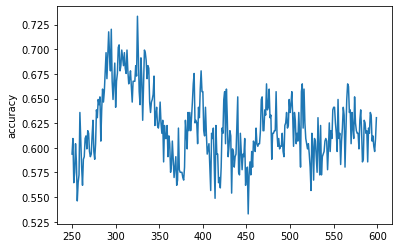

In [ ]:
x = [*range(250, 600)] 

plt.plot(x,accuracy)
plt.ylabel('accuracy')
plt.show()

# some small understanding of model and Plots.


Here, as mentioned, I used SVD, I use RBF as kerner with parameter gamma auto for training the model, however, I did not check every possible parameter, I decide based on several try and error. I also have checked several methods for reducing the dimentionality, like PCA and TSNE, but the result was not satisfiable. 

The plots showed that the results were expected, as the peak of accuracy is durring the period the subject saw the picture, between 100 ms to 600 ms.


Some of the 306 features showd stronger connection to the picture, with using feature selsction methods to find them, I beleive we can save the accuracy and decrease the run time.

Finally, normalizing the data, such as most of the other works about signals, increased the accuracy.